In [1]:
import cv2
import gi
import numpy as np
from threading import Thread, Event
from time import sleep
from pymavlink import mavutil
import matplotlib.pyplot as plt
from video import Video
from bluerov_interface import BlueROV
import lane_detection
import lane_following

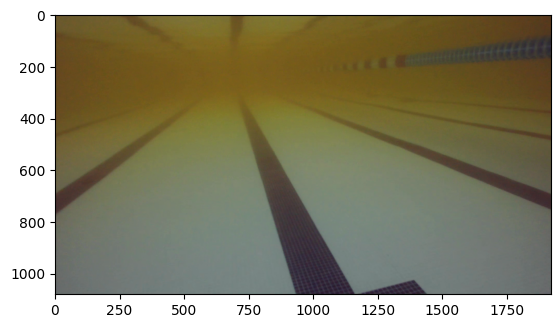

In [2]:
img = cv2.imread('rov_pool.jpg')

plt.imshow(img)

[[(array([[793, 606, 886, 929]], dtype=int32), array([-3.47311828]), array([967.48297214])), (array([[ 837,  526, 1156, 1078]], dtype=int32), array([-1.73040752]), array([1140.97463768]))], [(array([[1317,  505, 1698,  666]], dtype=int32), array([-0.42257218]), array([2512.0621118])), (array([[1336,  379, 1738,  457]], dtype=int32), array([-0.19402985]), array([3289.30769231]))]]
2
<class 'list'>
[(array([[793, 606, 886, 929]], dtype=int32), array([-3.47311828]), array([967.48297214])), (array([[ 837,  526, 1156, 1078]], dtype=int32), array([-1.73040752]), array([1140.97463768]))]
test: [967.48297214]


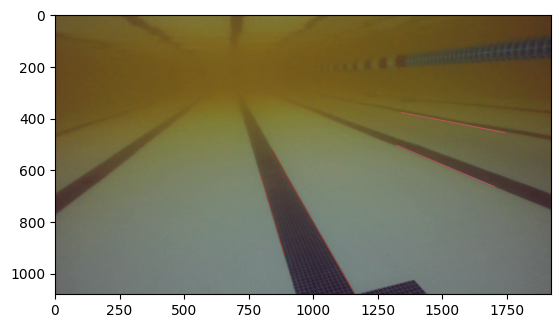

In [3]:
lines = lane_detection.detect_lines(img,600,1200, 5, 300, 20)
if lines is not None:
    lanes = lane_detection.detect_lanes(img,lines)
    print(lanes)
    print(len(lanes))
    print(type(lanes[0]))
    print(lanes[0])
    print(f"test: {lanes[0][0][2]}")
    lane_detection.draw_lanes(img,lanes)
    plt.imshow(img)
    cv2.imwrite("test_lane.png",img)



1080
[(array([[793, 606, 886, 929]], dtype=int32), array([-3.47311828]), array([967.48297214])), (array([[ 837,  526, 1156, 1078]], dtype=int32), array([-1.73040752]), array([1140.97463768]))]
intercepts: [array([967.48297214]), array([1140.97463768])]
[(array([[1317,  505, 1698,  666]], dtype=int32), array([-0.42257218]), array([2512.0621118])), (array([[1336,  379, 1738,  457]], dtype=int32), array([-0.19402985]), array([3289.30769231]))]
intercepts: [array([2512.0621118]), array([3289.30769231])]
closest_lane:[(array([[793, 606, 886, 929]], dtype=int32), array([-3.47311828]), array([967.48297214])), (array([[ 837,  526, 1156, 1078]], dtype=int32), array([-1.73040752]), array([1140.97463768]))]
center: [array([1054.22880491]), array([-0.38435478]), array([405.19787729])]
<class 'list'>


/tmp/ipykernel_1969/4112635441.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.line(img, (int(center[0]),height), (int((height-center[2])/center[1]), 0), (255, 0, 0), 5)
/tmp/ipykernel_1969/4112635441.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.circle(img, (int(center[0]),height), 20, (0, 0, 255), -1)


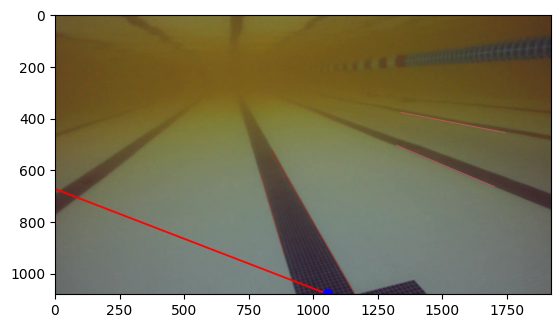

In [4]:
height, width, _ = img.shape
print(height)
center = lane_following.get_lane_center(img, lanes)
print(f"center: {center}")
print(type(center))
cv2.line(img, (int(center[0]),height), (int((-1*center[2])/center[1]), 0), (255, 0, 0), 5)
cv2.circle(img, (int(center[0]),height), 20, (0, 0, 255), -1)
plt.imshow(img)



In [5]:
# Create the video object
video = Video()

In [6]:
# Create the mavlink connection
mav_comn = mavutil.mavlink_connection("udpin:0.0.0.0:14550")

# Create the BlueROV object
bluerov = BlueROV(mav_connection=mav_comn)

frame = None
frame_available = Event()
frame_available.set()

def _get_frame():
    global frame
    while not video.frame_available():
        print("Waiting for frame...")
        sleep(0.01)

    try:
        while True:
            #print("HERE")
            if video.frame_available():
                frame = video.frame()
                lines = lane_detection.detect_lines(frame)
                if lines is not None:
                    lanes = lane_detection.detect_lanes(frame,lines)
                    print(lanes)
                    print(len(lanes))
                    lane_detection.draw_lanes(frame,lanes)
                    center = lane_following.get_lane_center
                else:
                    print("No lines detected")
            else:
                print("no frame")
                


    except KeyboardInterrupt:
        return


def _send_rc():
    global vertical_power, lateral_power
    bluerov.set_rc_channels_to_neutral()
    # bluerov.set_rc_channel(9, 1100)
    while True:
        bluerov.arm()
    


# Start the video thread
video_thread = Thread(target=_get_frame)
video_thread.start()

# Start the RC thread
rc_thread = Thread(target=_send_rc)
rc_thread.start()

# Main loop
try:
    while True:
        mav_comn.wait_heartbeat()
        #_get_frame()

except KeyboardInterrupt:
    video_thread.join()
    rc_thread.join()
    bluerov.set_rc_channels_to_neutral()
    bluerov.disarm()
    print("Exiting...")

In [ ]:
print('Initialising stream...')
waited = 0
while not video.frame_available():
    waited += 1
    print('\r  Frame not available (x{})'.format(waited), end='')
    if waited > 100:
        print("FAILED")
        break

print('\nSuccess!\nStarting streaming - press "q" to quit.')

In [ ]:
if video.frame_available():
    # Only retrieve and display a frame if it's new
    frame = video.frame()
    
else:
    print("Frame not found")